In [1]:
import os, sys
import numpy as np
import pandas as pd
from pprint import pprint
sys.path.append('scripts')

from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(images=True)

from Synthesis import localtransform

dataset = 'USPTO_480k'

model = localtransform(dataset)
model_parameters = filter(lambda p: p.requires_grad, model.model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print ('# model parameters: %.2fM' % (params/1e6))

loaded 4370 real templates
loaded 2535 virtual templates
Parameters of loaded LocalTransform:
{'attention_heads': 8, 'attention_layers': 3, 'edge_hidden_feats': 32, 'node_out_feats': 256, 'num_step_message_passing': 3, 'Template_rn': 4370, 'Template_vn': 2535, 'in_node_feats': 80, 'in_edge_feats': 13}
# model parameters: 9.09M


1th prediction: [A:1].[A:2]-[A:3]>>[A:1]-[A:2] A [7, 18] 0.8029191
2th prediction: [A:1].[A:2]-[A:3]>>[A:1]-[A:2] B [18, 19] 0.7632979
3th prediction: [A:1].[A:2]-[A:3]>>[A:1]-[A:2] B [15, 16] 0.57784003
4th prediction: [A:1].[A:2]-[A:3]>>[A:1]-[A:2] A [7, 15] 0.4794935
5th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] B [6, 7] 0.0048124576
6th prediction: [A:1].[A:2]-[A:3]>>[A:1]-[A:2] B [11, 9] 0.003228596
7th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] A [18, 6] 0.0021756282
8th prediction: [A:1].[A:2]-[A:3]>>[A:1]-[A:2] B [13, 14] 0.002029883
9th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] B [18, 19] 0.0016853069
10th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] A [6, 18] 0.0015002907
11th prediction: [A:1].[A:2]-[A:3]>>[A:1]-[A:2] A [7, 11] 0.0012986853
12th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] A [15, 6] 0.0010537269
13th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] A [6, 15] 0.0009257577
14th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] B [15,

,Reactants,Top-1,Top-2,Top-3,Top-4,Top-5
0,,,,,,

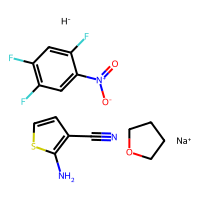
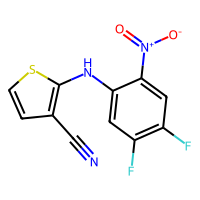
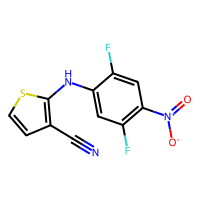
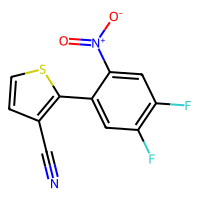
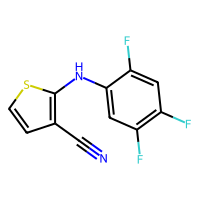
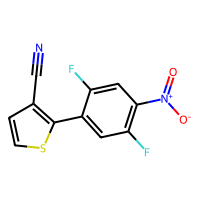

In [2]:
# Simple reaction outcome prediction
reactants = 'N#Cc1ccsc1N.O=[N+]([O-])c1cc(F)c(F)cc1F.C1CCOC1.[H-].[Na+]'
results_df, results_dict = model.predict_product(reactants, verbose = 1)
# pprint (results_dict)
results_df

In [3]:
from tqdm import tqdm
from rdkit import Chem

url = 'https://github.com/connorcoley/rexgen_direct/blob/master/human/benchmarking.xlsx?raw=true'
human_benchmark_rxns = pd.read_excel(url)['Reaction smiles'][:80]

batch_size = 16
reactants = []
products = []
scores = []
for rxns in tqdm(zip(*(iter(human_benchmark_rxns),) * batch_size), total = len(human_benchmark_rxns)//batch_size):
    reactant_list = [rxn.split('>>')[0] for rxn in rxns]
    results_df, results_dict = model.predict_product(reactant_list, topk=1, verbose = 0)
    for reactant, result in results_dict.items():
        reactants.append(Chem.MolFromSmiles(reactant))
        products.append(Chem.MolFromSmiles(result['Top-1']['product']))
        scores.append(result['Top-1']['score'])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.93s/it]


,Reactants,Top-1 products,Scores
0,,,0.947642
1,,,0.668431
2,,,0.996591
3,,,0.993130
4,,,0.609021
5,,,0.524101
6,,,0.994527
7,,,0.871600
8,,,0.913668
9,,,0.999624

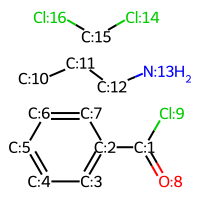
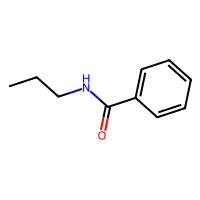
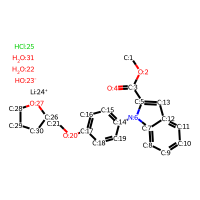
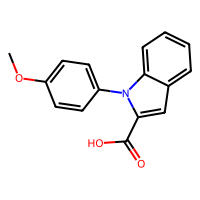
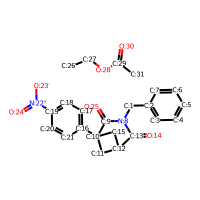
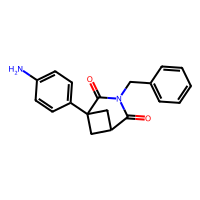
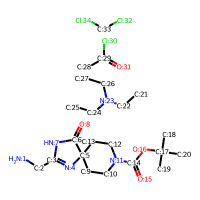
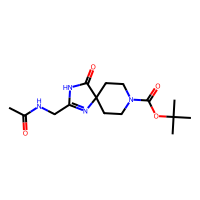
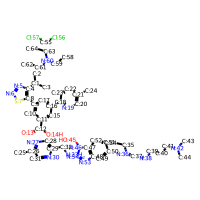
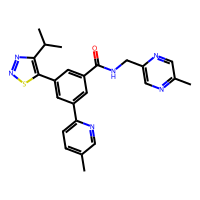
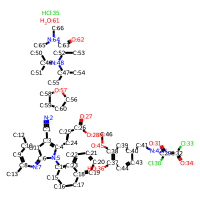
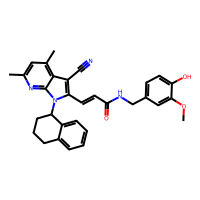
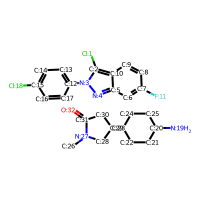
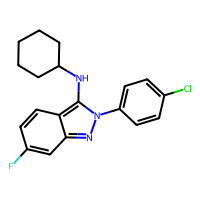
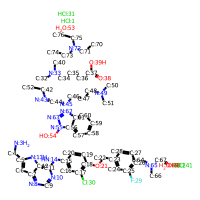
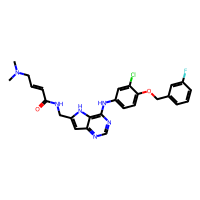
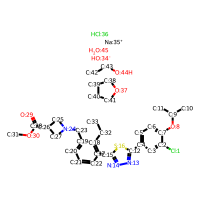
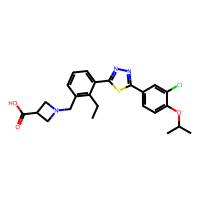
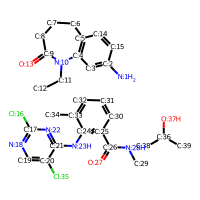
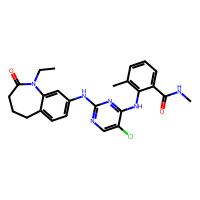
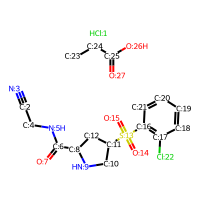
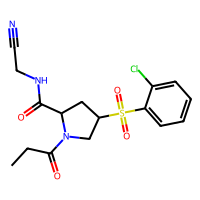
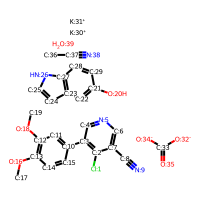
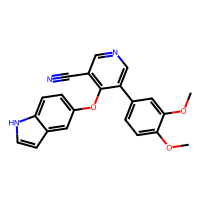
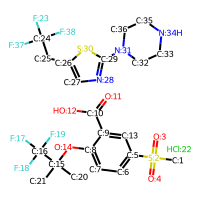
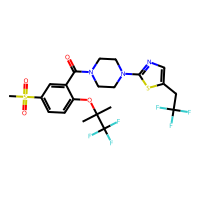
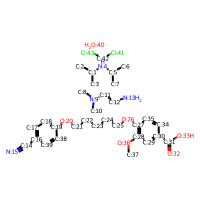
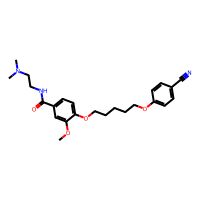
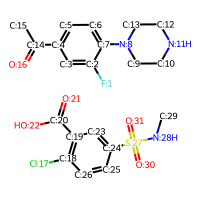
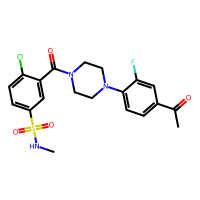
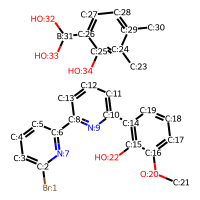
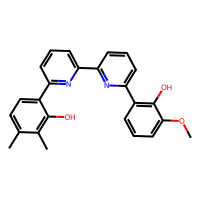
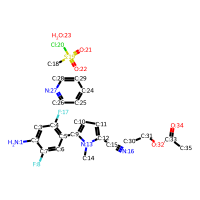
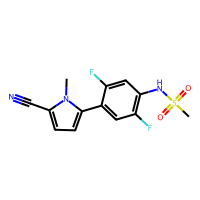
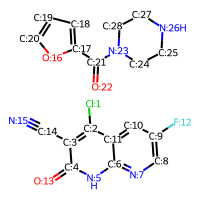
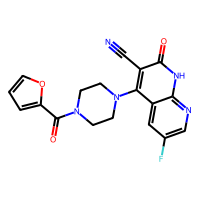
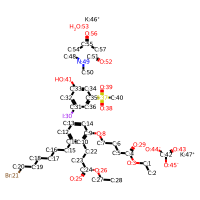
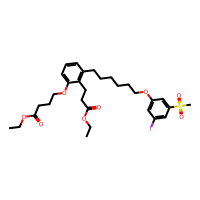
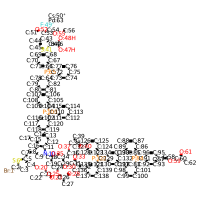
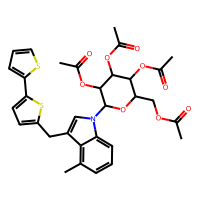
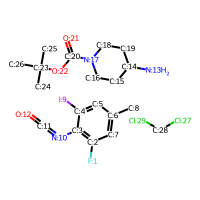
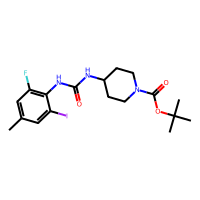
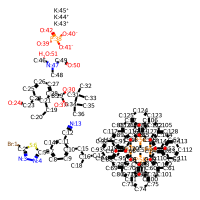
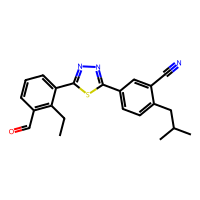
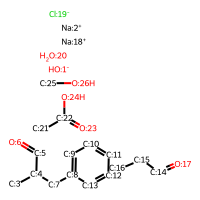
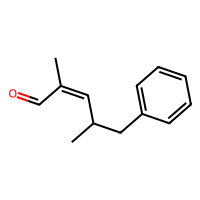
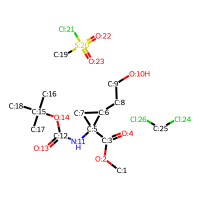
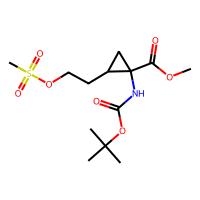
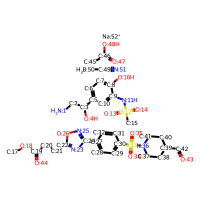
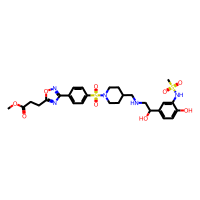
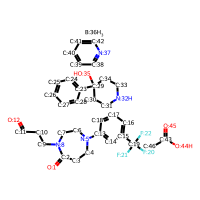
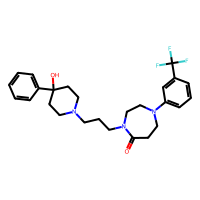
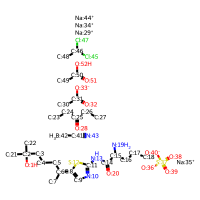
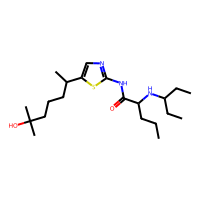
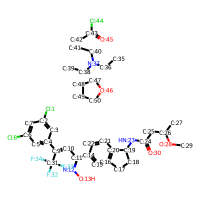
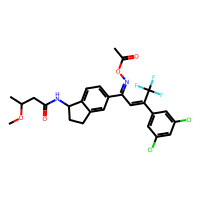
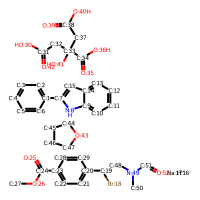
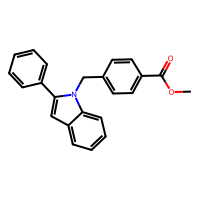
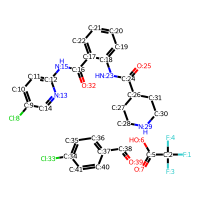
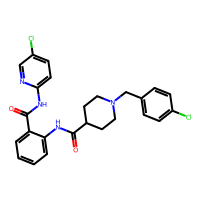
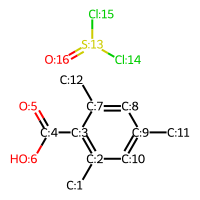
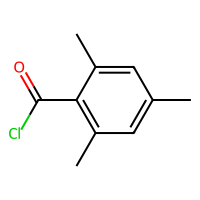
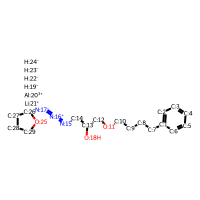
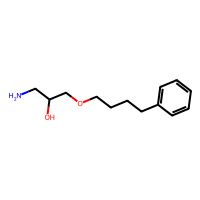
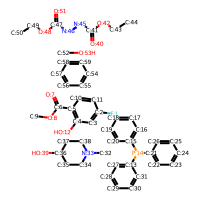
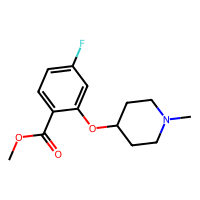
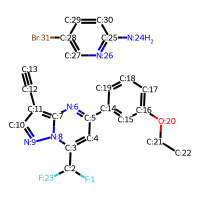
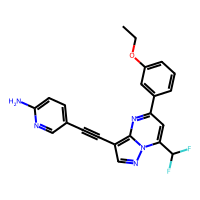
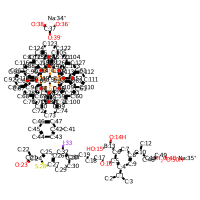
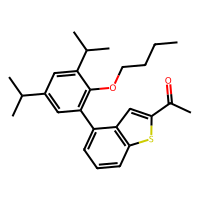
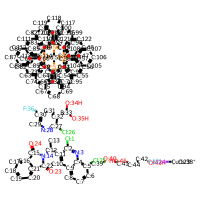
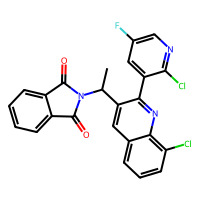
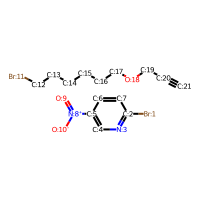
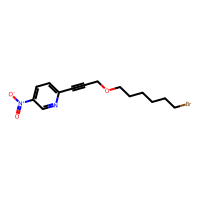
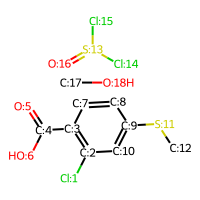
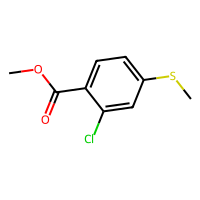
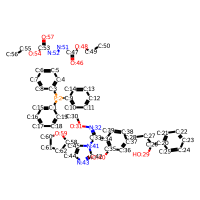
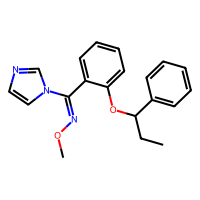
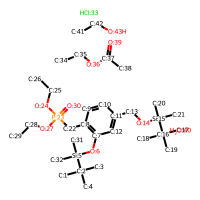
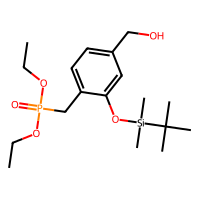
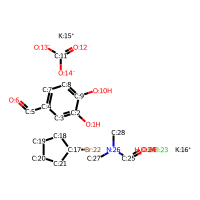
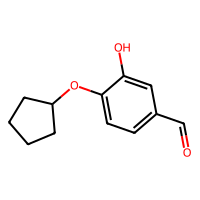
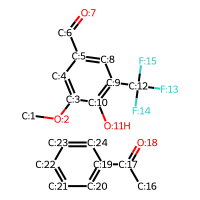
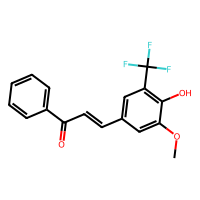
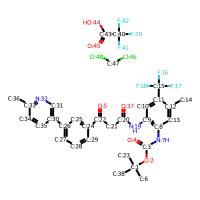
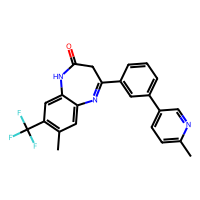
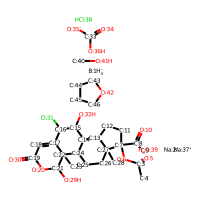
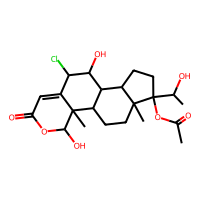
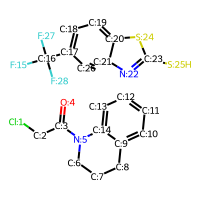
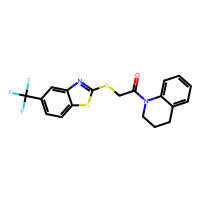
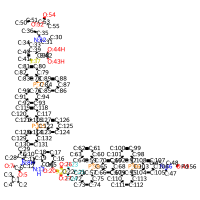
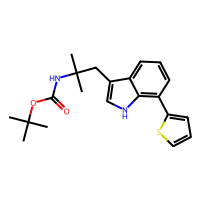
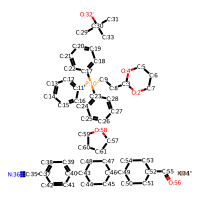
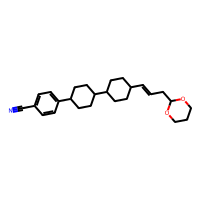
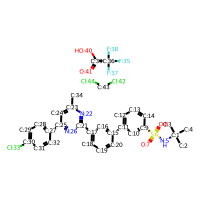
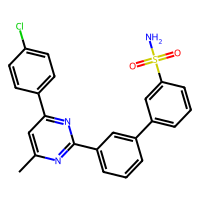
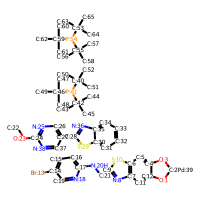
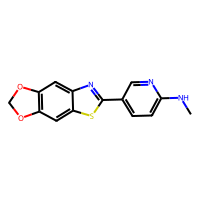
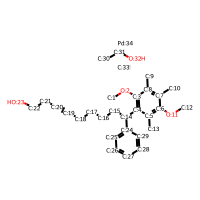
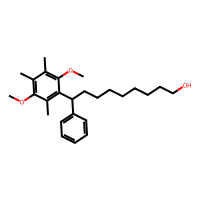
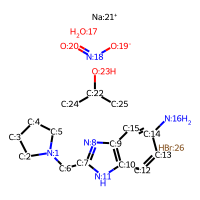
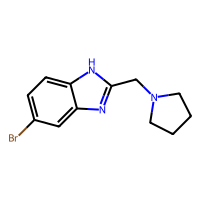
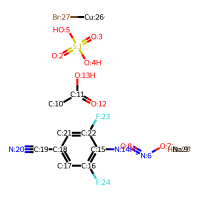
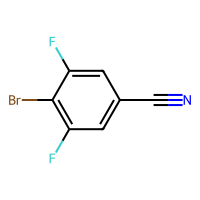
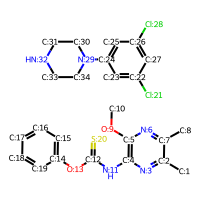
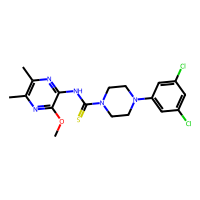
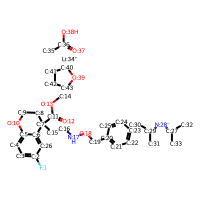
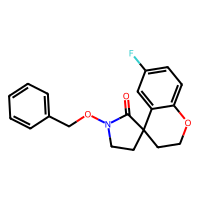
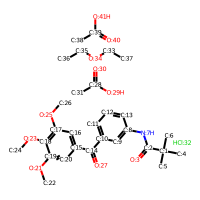
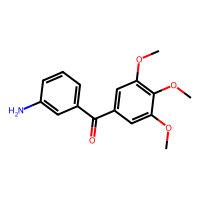
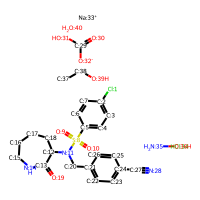
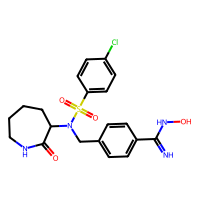
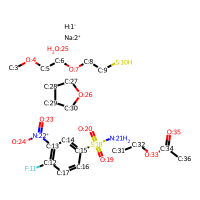
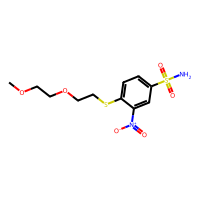
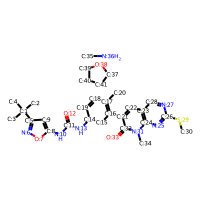
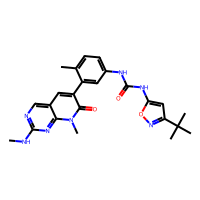
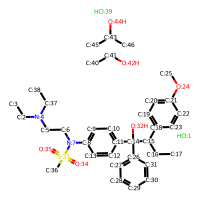
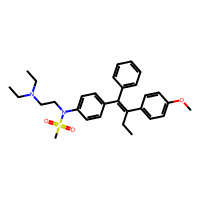
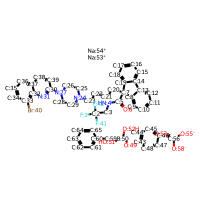
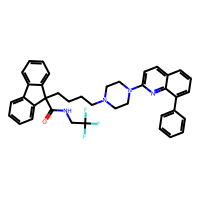
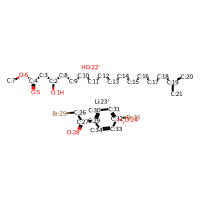
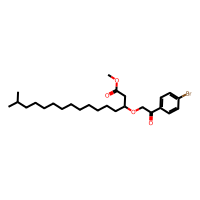
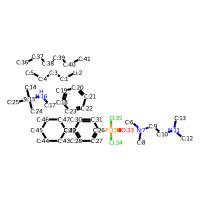
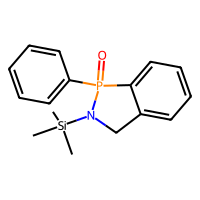
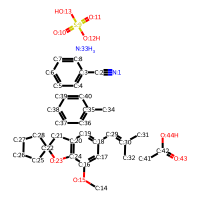
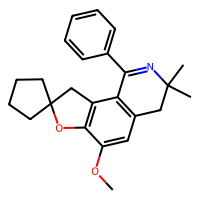
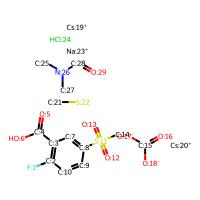
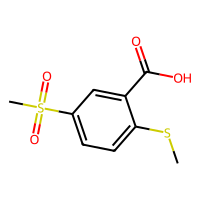
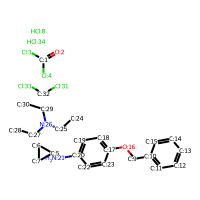
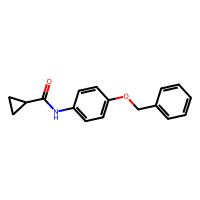
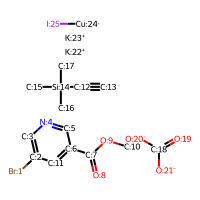
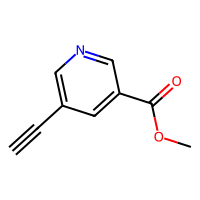
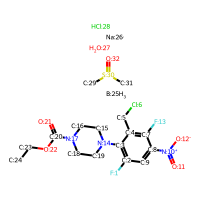
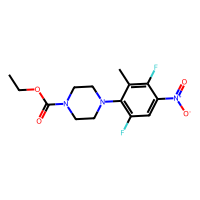
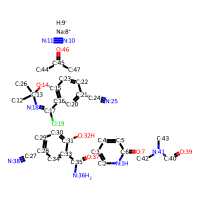
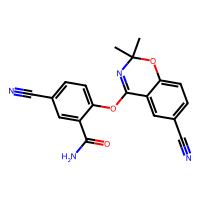
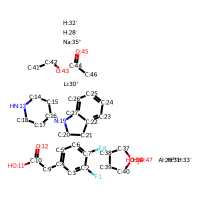
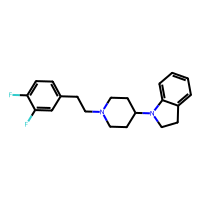
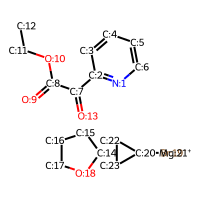
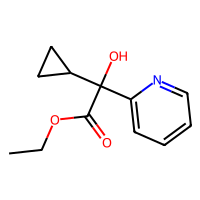
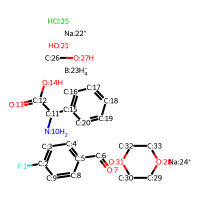
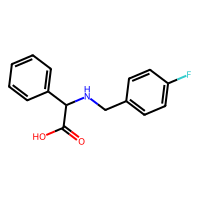
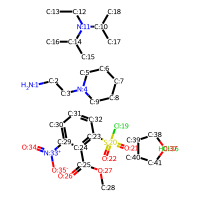
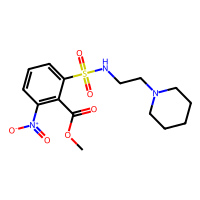
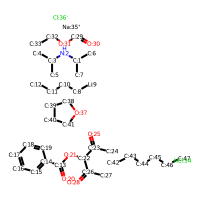
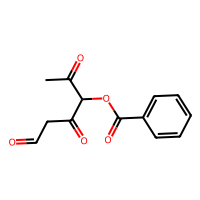
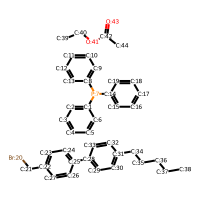
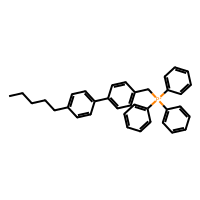
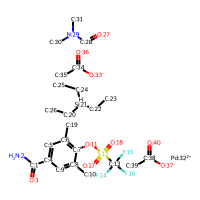
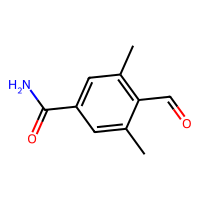
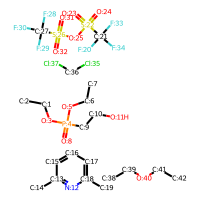
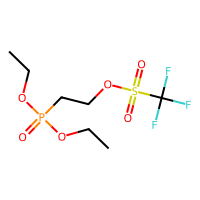
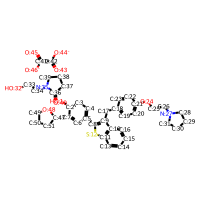
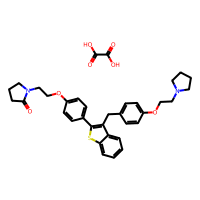
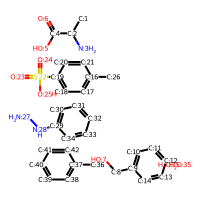
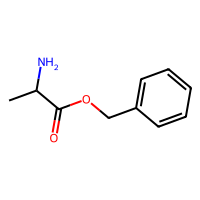
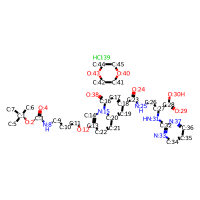
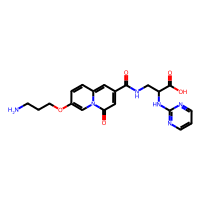
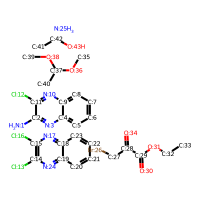
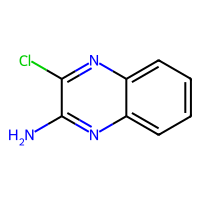

In [4]:
pd.set_option('display.max_rows', None)
pd.DataFrame({'Reactants':reactants, 'Top-1 products': products,  'Scores': scores})